# Úloha 2: nasazení pokročilé heuristiky

Dominik Dosoudil

dosoudom

03.01.2023

## Zadání

**Řešení problému max. vážené splnitelnosti booleovské formule (MWSAT) pokročilou iterativní metodou**

Popis problému: https://courses.fit.cvut.cz/NI-KOP/problems/sat.html#mwsat

Problém řešte některou z pokročilých heuristik:

- simulované ochlazování
- genetický algoritmus

Detail zadání: https://courses.fit.cvut.cz/NI-KOP/homeworks/files/task2.html

## Implementace

Pro řešení problému jsem si vybral variantu **simulované ochlazování** (SA). Heuristiku jsem implementoval v jazyce **Rust**, který je z mého pohledu pro tuto úlohu vhodný vzhledem k jeho rychlosti a jelikož je problém řešen jednovláknově, nebudou dělat překážku ani mechaniky jazyka pro práci s pamětí.

Základ SA:

```rust
    // Nejprve nastavíme nějakou počáteční teplotu, konkrétní metoda bude popsána později.
    let mut t = compute_initial_temperature(&mut rng, &f, &value);

    // Vygenerujeme náhodný počáteční stav.
    let mut state = TruthAssignment::new_random(f.vars_n, &mut rng);

    // Algoritmus simulovaného ochlazování běží ve 2 úrovních smyček.
    // Ve vnější smyčce iterujeme dokud není splněna podmínka zamrznutí, tedy teplota neklesne pod stanovenou hodnotu.
    while !frozen(t) {
        // Vnitřní smyčka běží fixní počet kroků definovaný v konstanntě "EQUILIBRIUM".
        for _ in 0..EQUILIBRIUM {
            // V každé iteraci si vybereme náhodného souseda aktuálního stavu.
            // (pozn.: Do funkce next_state předávám generátor náhodných čísel aby bylo možené v případě debugování použít PRNG se seedem)
            let new_state = next_state(&mut rng, state.clone());
            
            // Vypočteme hodnotu obou stavů.
            let state_value = value(&state, &f);
            let new_state_value = value(&new_state, &f);

            // Pokud je nový stav lepší (má vyšší hodnotu), přejdeme do něj.
            if new_state_value > state_value {
                state = new_state;
            // V případě zhoršení do něj přejdeme pokud funkce accept vrátí true,
            // což je založeno na náhodě, aktuální teplotě a velikosti zhoršení.
            } else if accept(&mut rng, (state_value - new_state_value) as f64, t) {
                state = new_state;
            }
        }
        // Nakonec každé iterace vnější smyčky snížíme teplotu.
        t = cool_down(t);
    }

```
### Inicializace teploty (compute_initial_temperature)

Vysoká teplota nám v podstatě zvyšuje šanci přijetí horšího stavu, což zapříčiní rozšíření zkoumaného prostoru. Proto potřebujeme počáteční teplotu dost vysokou, aby byl prozkoumaný prostor dostatečně velký.

Jelikož řeším problém vážené splnitelnosti, musí počáteční teplota odrážet i váhy proměnných. K obecným metodám zmíněným v přednášce se zde nabízí odhad počáteční teploty na základě počtu proměnných, počtu klauzulí a například průměru vah. Nakonec jsem se nicméně rozhodl pro obecnou metodu sledování četnosti přijetí při zvyšování teploty. Tu jsem provedl tak, že ve smyčce zvyšuji teplotu o nějakou konstantu a v každé iteraci si vygeneruji 10 náhodných stavů a jejich sousedů, spočtu pravděpodobnost přijetí a pokud průměr z těchto pravděpodobností přijetí je vyšší než 0.5, vrátím aktuální teplotu.

Díky tomu je výběr počáteční teploty dynamický a není třeba jej ladit ve white box fázi.

### Výběr souseda (next_state)

Při výběru náhodného souseda zneguji ohodnocení náhodné proměnné v aktuálním stavu.

### Hodnota stavu (value)

Hodnota stavu je součet vah proměnných ohodnocených na true (1).
Nicméně jelikož by se mohlo stát, že SA začne upřednostňovat taková řešení, která ohodnotí hodně proměnných na true ačkoli takové ohodnocení nesplní formuli, musíme hodnotu penalizovat pokud jsou některé klauzule nesplněné. Tedy součet vah zmenšíme o počet nesplněných klauzulí vynásobených nějakou penalizační konstantou.

#### Penalizační konstanta

V přednášce máme uvedenou jako penalizační konstantu hodnotu 1000. Nicméně tato hodnota by mohla být moc malá pokud bychom měli velké váhy. Proto musí penalizační konstanta odrážet velikost vah. Zde by mohl dobře fungovat například průměr vah.

Tento průměr vah ještě přenásobím hodnotou 4, což je popsáno ve white box testování.

### Předběžné ukončení ()

Pro předběžné ukončení jsem zkusil 2 metody.

První jednodušší v každé iteraci zkusila, zdali je relativní změna hodnoty oproti předchozí iteraci menší než nějaká malá konstanta. Pokud ano, snížila counter o 1, pokud ne, resetovala counter. Pokud counter došel k 0, ukončila SA. Nicméně tato metoda se moc neosvědčila.

Druhá metoda každou vnější iteraci vezme posledních 2500 hodnot a spočítá relativní odchylku. Pokud je tato relativní odchylka menší než nějaká malá konstanta, ukončí výpočet.

### Ochlazení (cool_down)

Ochlazování se provádí vynásobením aktuální teploty nějakou konstantou menší než 1.

White box testování úkázalo jako vhodný koeficient hodnotu 0.97.

### Zamrznutí (frozen)

Protože počáteční teplota je nastavena dynamicky na základě problému, nastavím i minimální teplotu závisle na počáteční. Tím bych měl teoreticky docílit podobné doby běhu nezávisle na velikosti instance.

Vydělím tedy počáteční teplotu mocninou 10. Tato mocnina bude parametrizovatelná a vyzkoušená ve white box fázi.


### Parametry programu
výpis --help
```
Options:
  -i, --input <INPUT>
          
  -c, --cooling-ratio <COOLING_RATIO>
          [default: 0.995]
  -m, --min-temperature <MIN_TEMPERATURE>
          [default: 5]
  -p, --penalty-multiplier <PENALTY_MULTIPLIER>
          [default: 4]
      --tail-cut-length <TAIL_CUT_LENGTH>
          [default: 2500]
      --tail-cut-method <TAIL_CUT_METHOD>
          [default: relative-deviation] [possible values: relative-deviation, relative-change]
  -h, --help
          Print help information

```

## Experimenty

Při všech experimentech měřím počet iterací vnitřní smyčky (tedy počet změn stavu). Tedy nezáleží na HW.

### White box

V této fázi experimentu se budu věnovat výběru parametrů pro nastavení algoritmu tak, aby průběh fungoval dobře pro reprezentanty různých velikostí instancí.
Jako reprezentanty náhodně vybírám:
 - data/wuf20-91R/wuf20-91R-R/wuf20-0118.mwcnf
     - optimum: 15021
 - data/wuf50-218R/wuf50-218R-Q/wuf50-0311.mwcnf
     - optimum: 463
 - data/wuf75-325/wuf75-325-M/wuf75-078.mwcnf
     - optimum: 25743

#### Velikost penalizace

Jako první bych rád správně nastavil penalizaci, abych zajistil, že nevalidní stavy (stavy, které mají nenulový počet nesplněných klauzulí) nebudou mít hodnotu větší než stavy validní. Díky tomu by pak SA mělo preferovat stavy, které splňují všechny klauzule a tedy nejlepší z takových stavů by i měl být výsledkem algoritmu.

Jak jsem již zmínil v řešení, jako penalizaci místo hodnoty 1000 používám průměr vah ze zadání problému. Tento průměr ale možná ještě bude potřeba přenásobit nějakým multiplikátorem.

Konfigurace:
|||
|-|-|
|cooling ratio|0.995|
|minimal temperature|5.0|

Zkoušené multiplikátory penalizace:

|multiplier | input | value |
|-------|---|---|
| 1     | wuf20-0118 | 26989 |
| 1     | wuf50-0311 | 6331  |
| 1     | wuf75-078  | 25830 |
| 4     | wuf20-0118 | 15956 |
| 4     | wuf50-0311 | 4806  |
| 4     | wuf75-078  | 25743 |
| 8     | wuf20-0118 | 15021 |
| 8     | wuf50-0311 | 3641  |
| 8     | wuf75-078  | 25743 |


Z následujících grafů můžeme vidět, že pro hodnotu 1 je více nesplněných klauzulí. Pro hodnotu 4 už méně a pro hodnotu 8 ještě méně. Nicméně pokud bude multiplikátor moc velký, zbytečně nám bude velmi snižovat hodnotu a zvětšovat rozsah možných hodnot. Zároveň je na grafu vidět, že průběh již není tak dobrý. Proto vybírám hodnotu **4**.

multiplier = 1

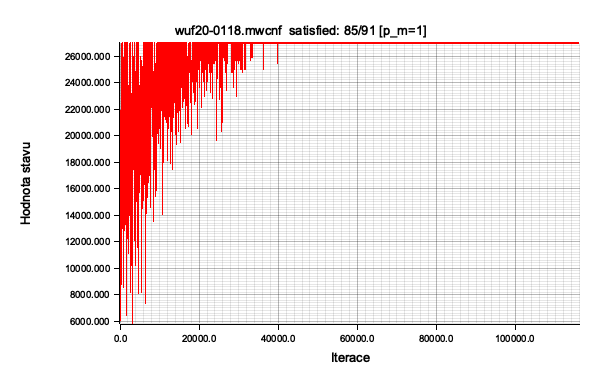
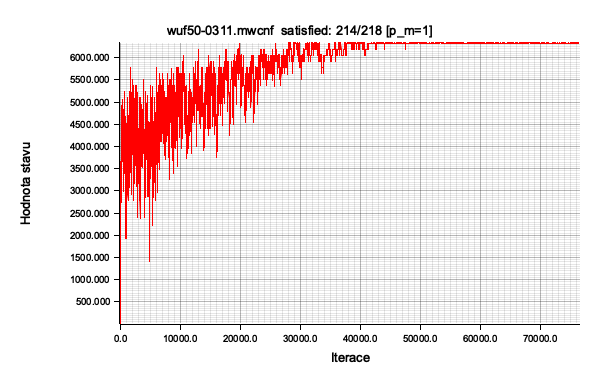
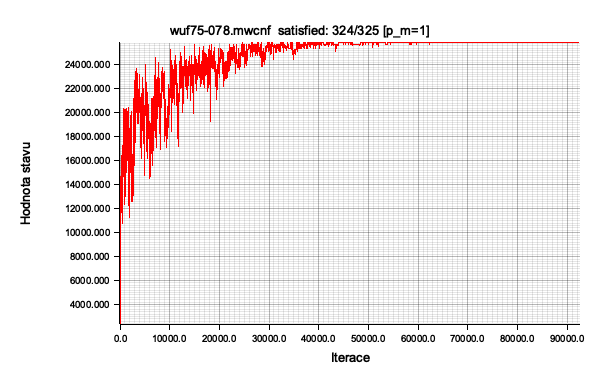


multiplier = 4

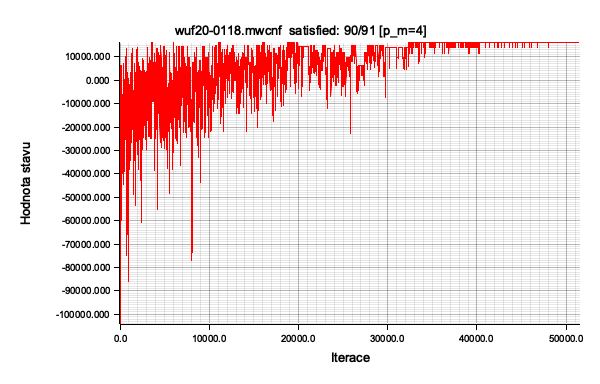
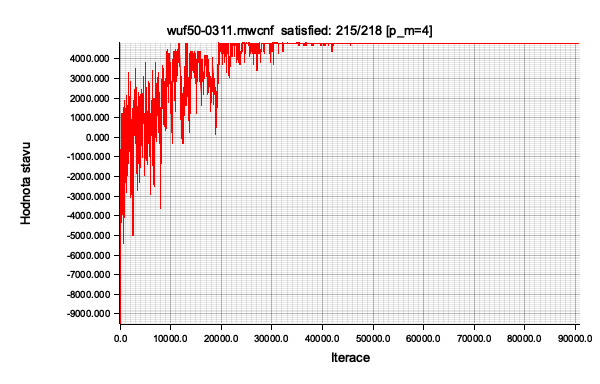
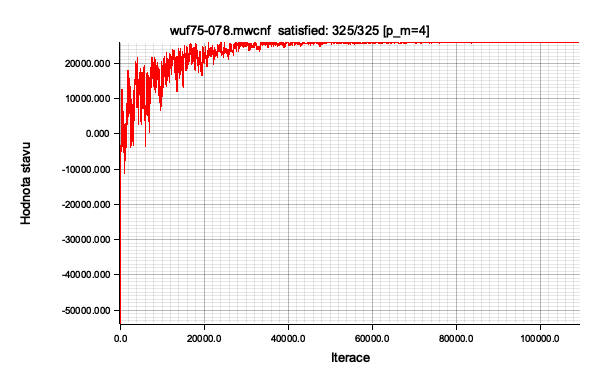

multiplier = 8

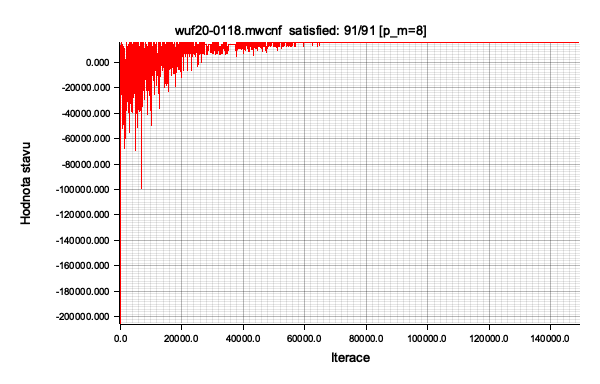
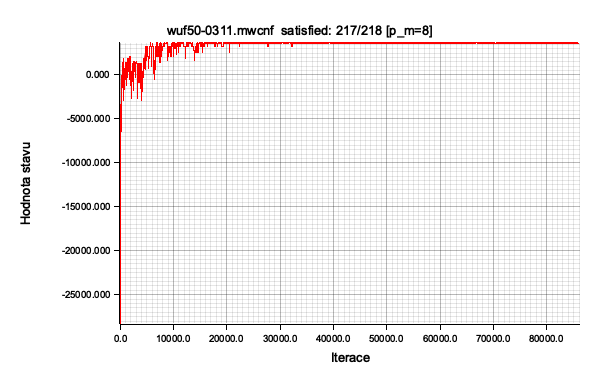
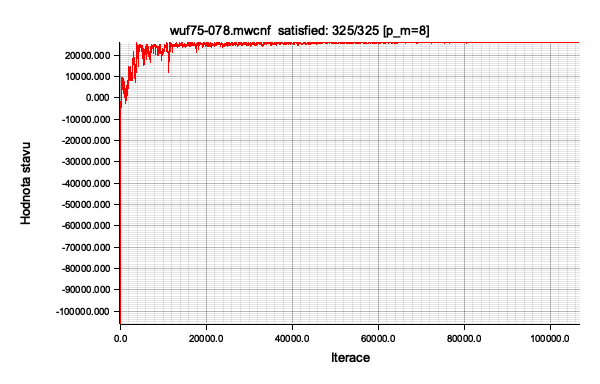

#### Ochlazovací koeficient

Ochlazovací koeficient je jeden z parametrů, který nám omezuje maximální dobu běhu (s menším koeficientem klesá teplota rychleji a dříve zamrzne algoritmus). Na druhou stranu ale v podstatě určuje kolik má SA prostoru pro volnější prozkoumávání stavového prostoru. Pokud se teplota ochladí moc brzy, brzy se i přestanou přijímat zhoršující stavy.

Obvykle se ochlazovací koeficient nastavuje na hodnoty v rozmezí 0.8 - 0.99. Proto také zkusím hodnoty z tohoto rozmezí.

|cooling coefficient| input | value |
|---|---|---|
| 0.85 | wuf20-0118 | 14285 |
| 0.85 | wuf50-0311 | 4380  |
| 0.85 | wuf75-078  | 25743 |
| 0.9  | wuf20-0118 | 15956 |
| 0.9  | wuf50-0311 | 4496  |
| 0.9  | wuf75-078  | 25743 |
| 0.95 | wuf20-0118 | 15956 |
| 0.95 | wuf50-0311 | 4380  |
| 0.95 | wuf75-078  | 25743 |
| 0.97 | wuf20-0118 | 15956 |
| 0.97 | wuf50-0311 | 4806  |
| 0.97 | wuf75-078  | 25743 |
| 0.99 | wuf20-0118 | 15956 |
| 0.99 | wuf50-0311 | 4806  |
| 0.99 | wuf75-078  | 25743 |

Z následujících grafů je vidět, že pro hodnoty 0.85 - 0.95 se moc nemění hodnoty stavů a prostor není dostatečně prozkoumán. Lepší mi přijdou vyšší hodnoty. Může to být dané zafixováním hodnoty ekvilibria na malou hodnotu. Nicméně i tak pro koeficient 0.97 vypadá průběh SA dobře a proto volím tuto hodnotu. Vyšší hodnota 0.99 už zbytečně prodlužuje výpočet.

cooling coefficient = 0.85

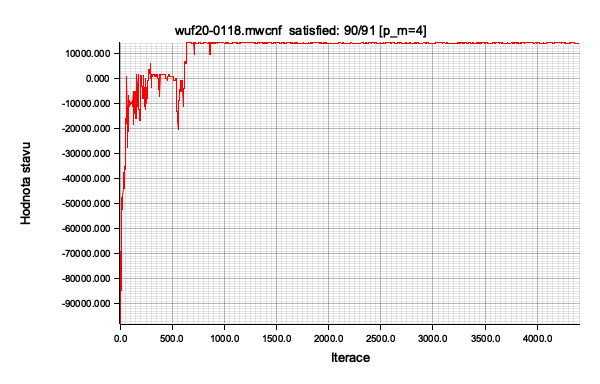
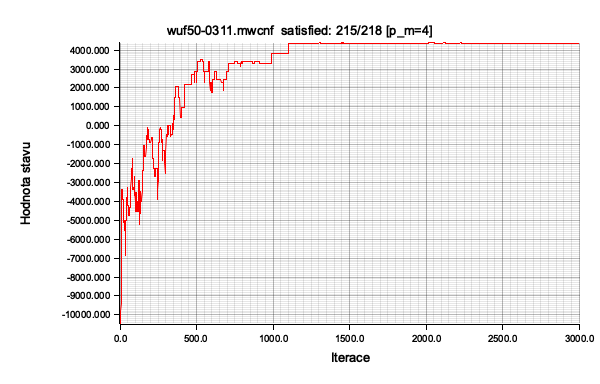
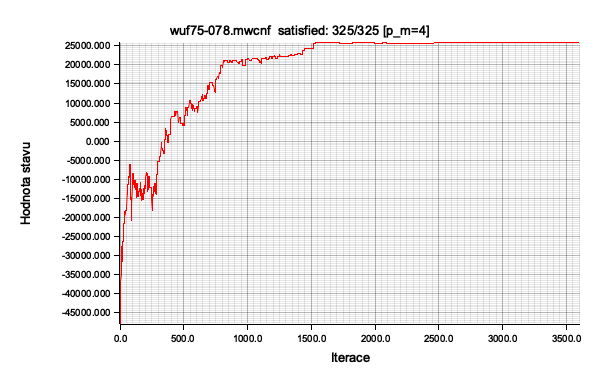

cooling coefficient = 0.9

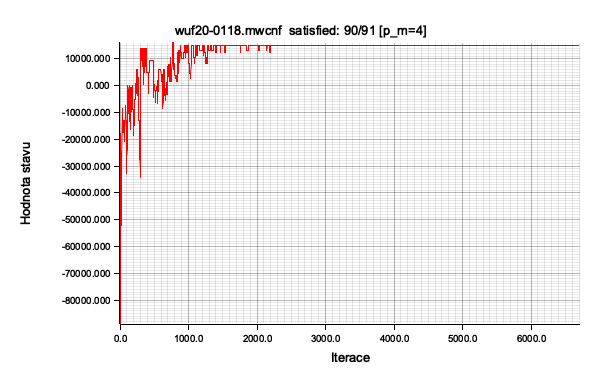
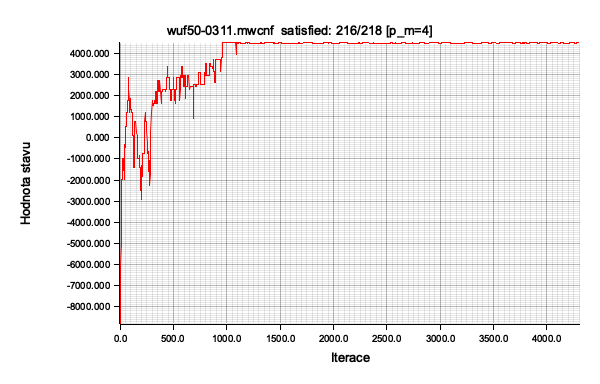
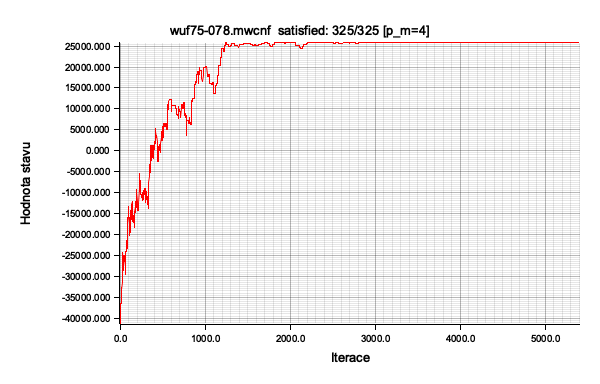

cooling coefficient = 0.95

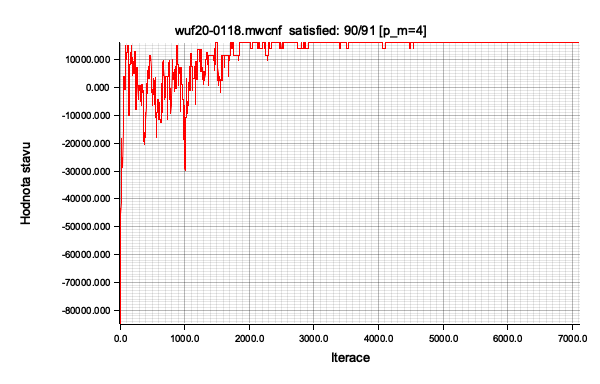
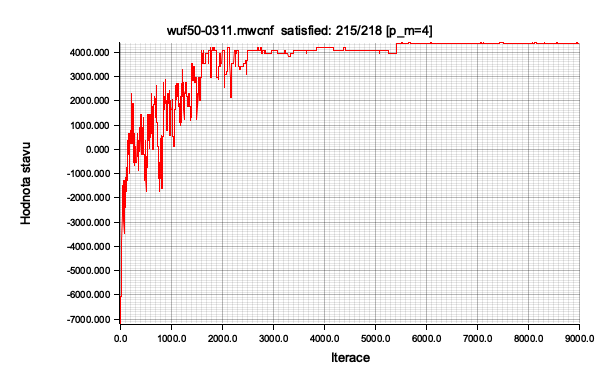
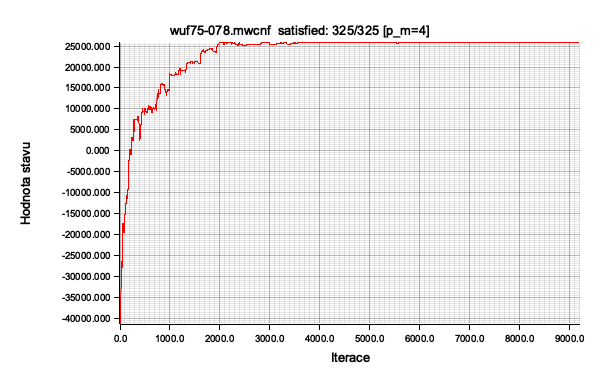

cooling coefficient = 0.97

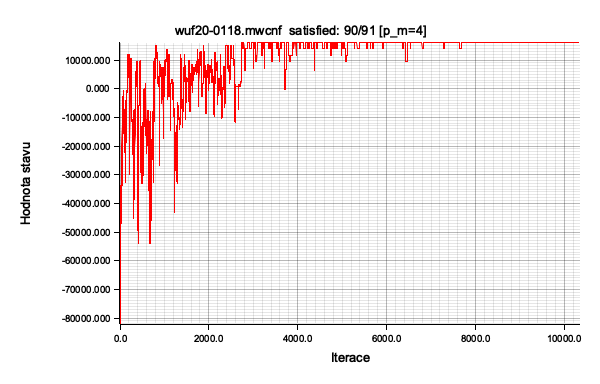
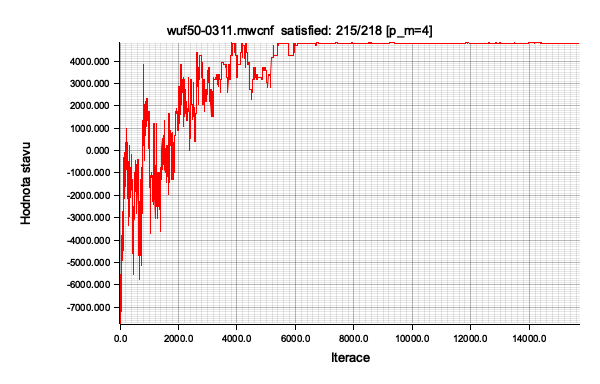
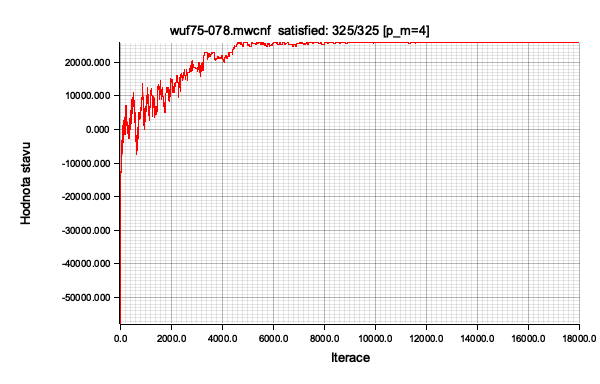


cooling coefficient = 0.99

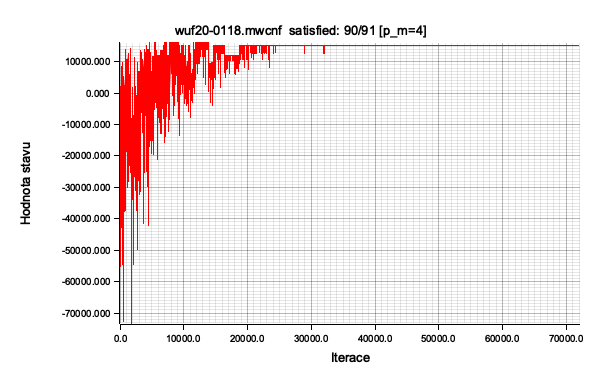
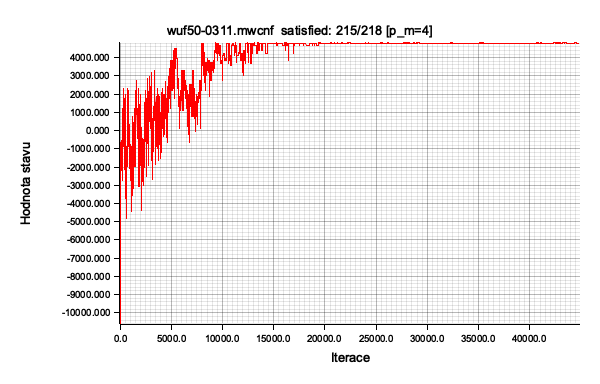
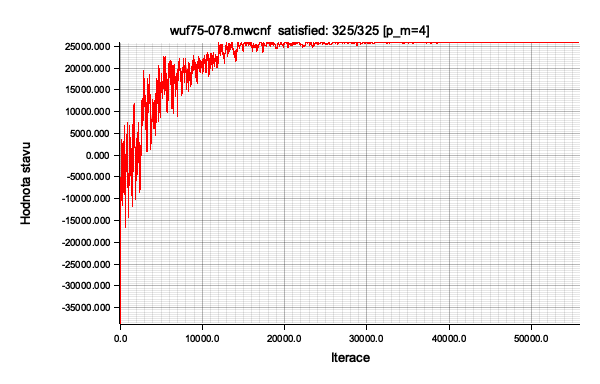

#### Zamrznutí

Minimální teplota, tedy teplota, při které SA ukončí výpočet, je další parametr participující na maximální době běhu. Pokud nebude o dost menší než počáteční teplota, tak se algoritmus vypne dříve než dokonverguje k nějaké ustálené hodnotě. Proto by měla být minimální teplota dostatečně nízká.

Zkusím nastavit $ x $, kde minimální teplota bude $ t_{min} = \frac{t_{init}}{10^x} $.


|x||
|-|-|
|1||
|**2**||
|4||
|8||
|10||


Z grafů je vidět, že pro mocninu 1 skončí výpočet moc brzy a nebyl dostatek času pro konvergování.
Pro hodnotu 2 je již čas na konvergenci dostatečný a tedy volím tuto hodnotu, protože zbytečně snižovat minimální teplotu by přineslo akorát prodloužení výpočtu.

x = 1

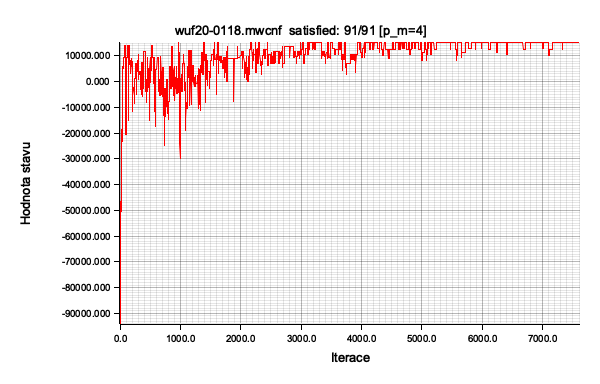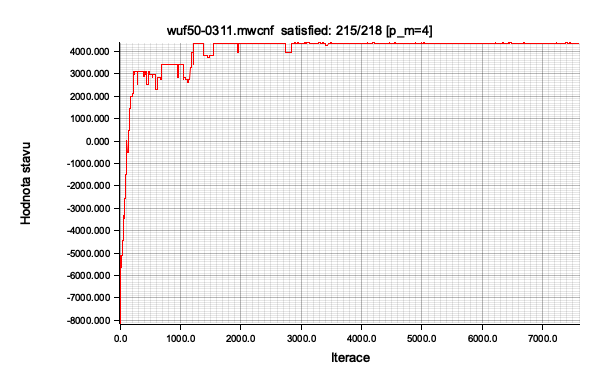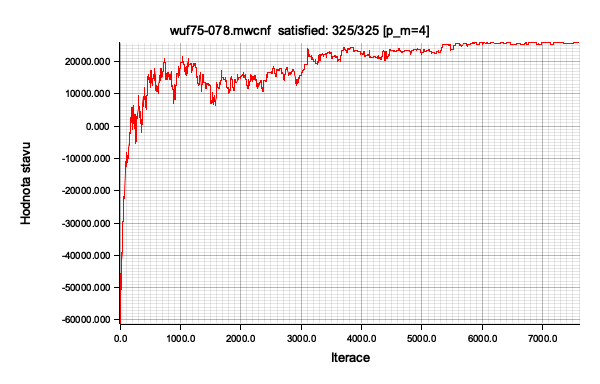

x = 2

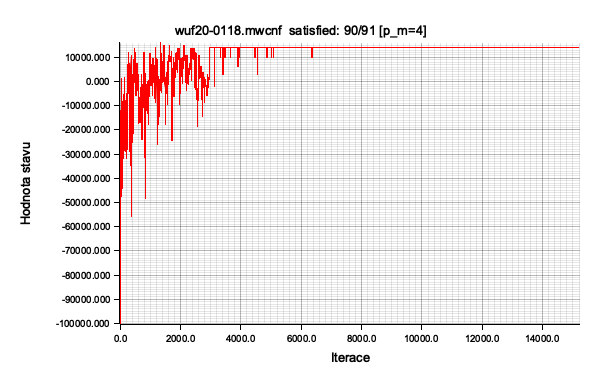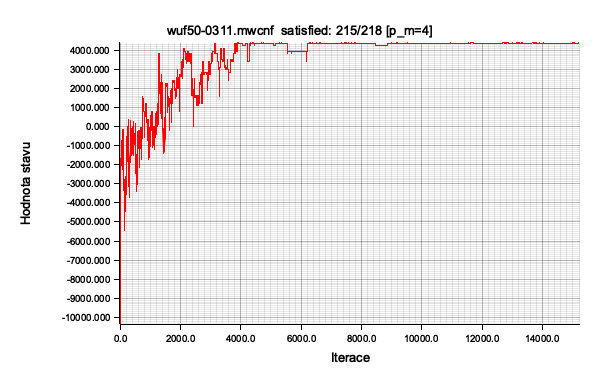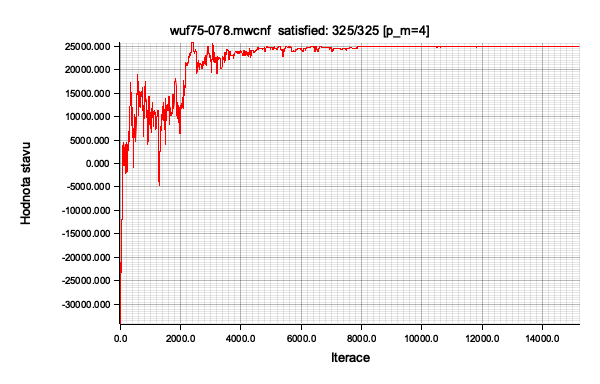

x = 4

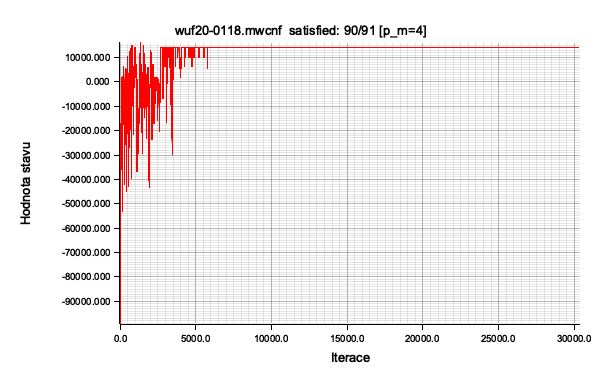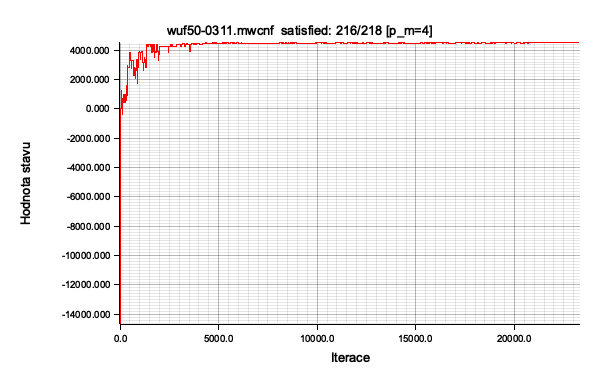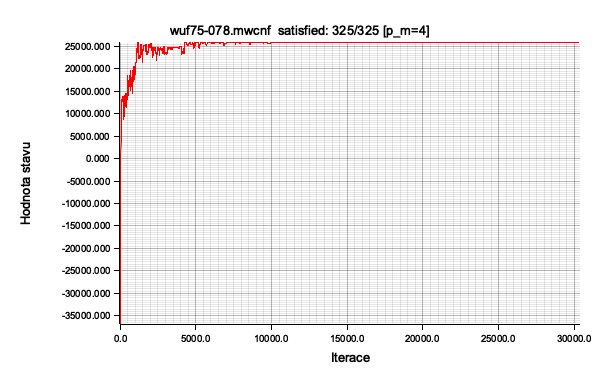

x = 8

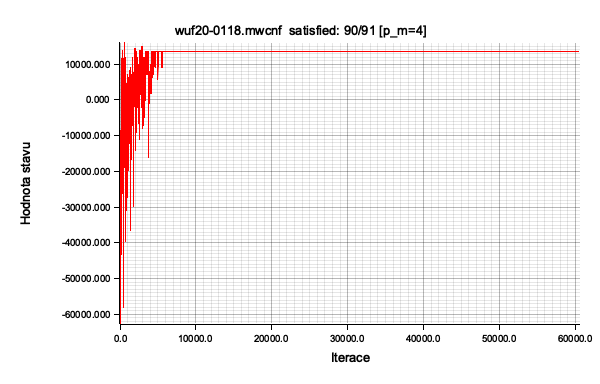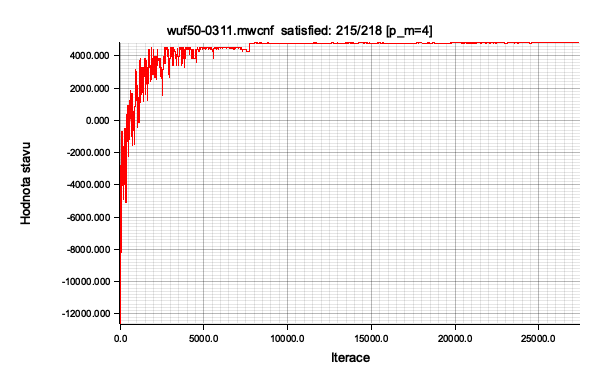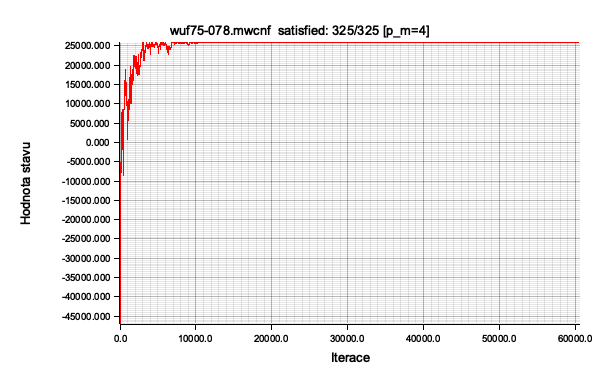


#### Metodika předběžného ukončení (tail cut)

Jelikož jsem implementoval 2 různé metody předběžného ukončení a navíc lze parametrizovat kolik posledních hodnot bude metoda zkoumat, provedu kombinace těchto nastavení najednou.

| method | last_values_n | wuf20-0118 value | wuf50-0311 value | wuf75-078 value |
|-|-|-|-|-|
|relative-change    | 100  | 15956 | -2266 | -8548 |
|relative-change    | 800  | 15021 | 4806 | 25743 |
|relative-change    | 3000 | 15021 | 3955 | 25743 |
|relative-deviation | 100  | 15956 | 4806 | 25743 |
|relative-deviation | 800  | 15021 | 4806 | 25743 |
|relative-deviation | 3000 | 15956 | 4496 | 25743 |

method = relative-change, last_values_n = 100

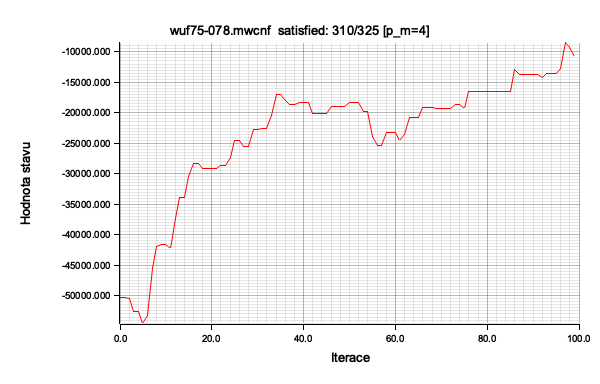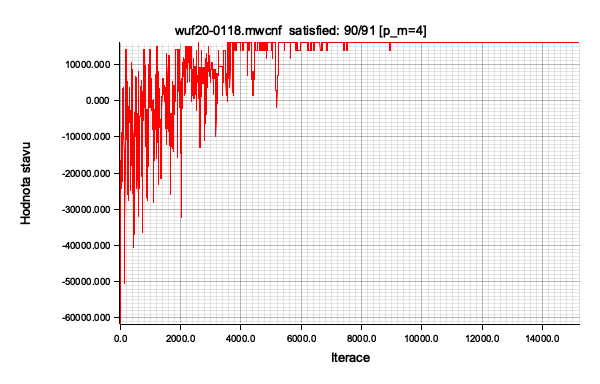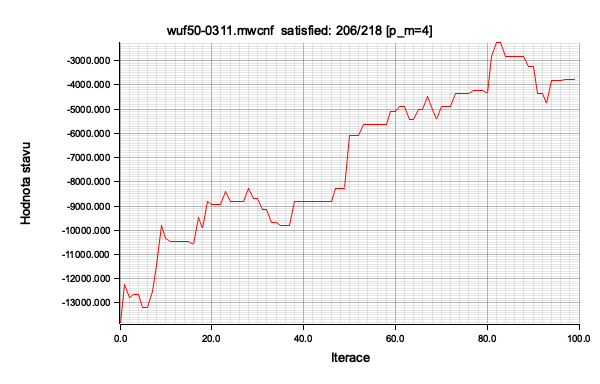

method = relative-change, last_values_n = 800

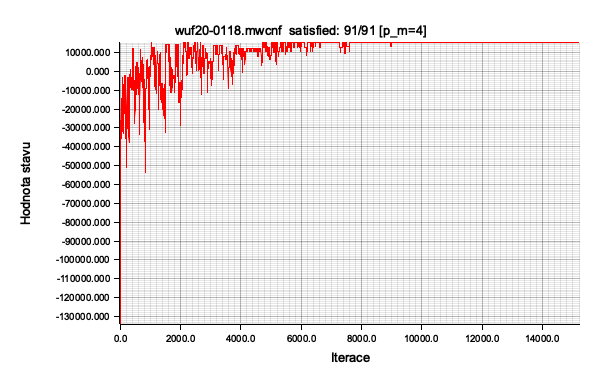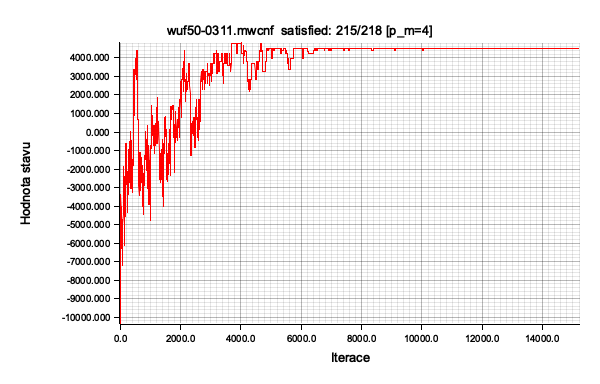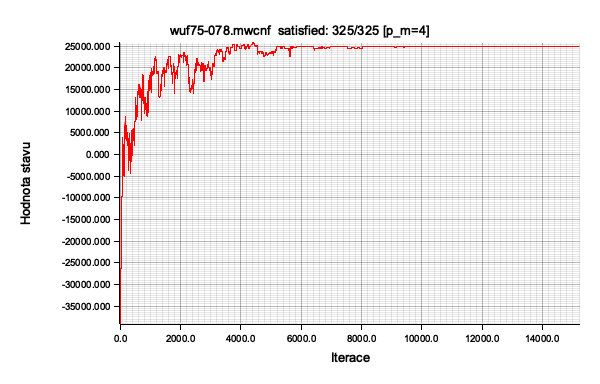

method = relative-change, last_values_n = 3000

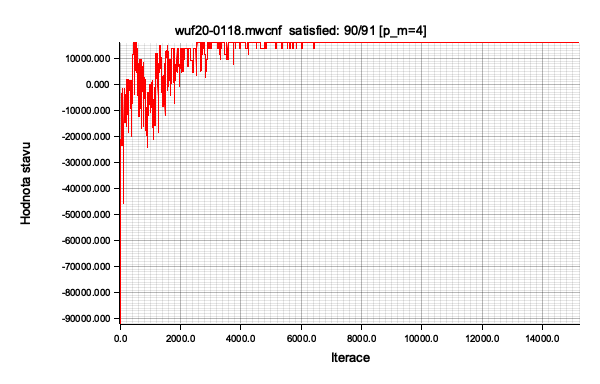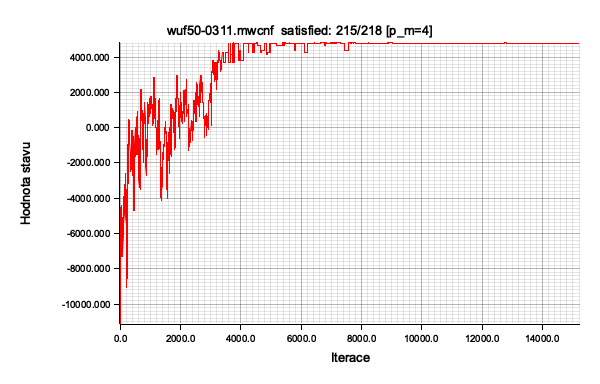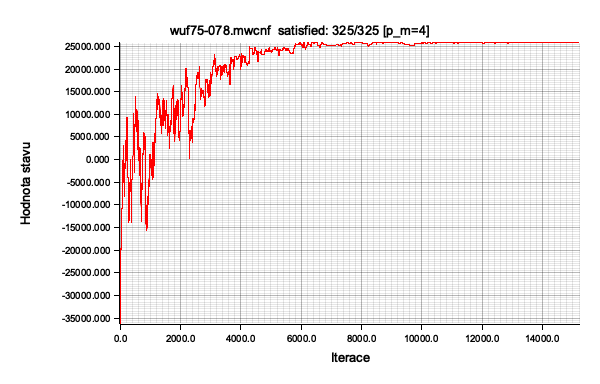

method = relative-deviation, last_values_n = 100

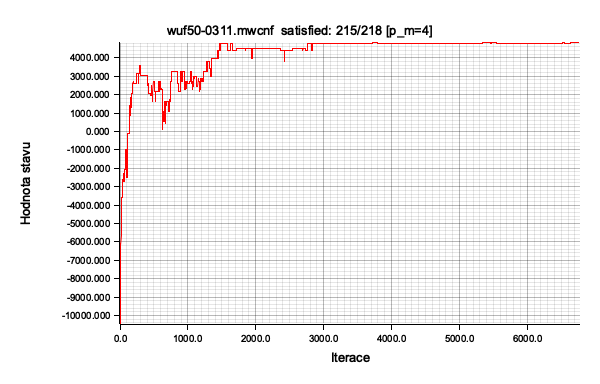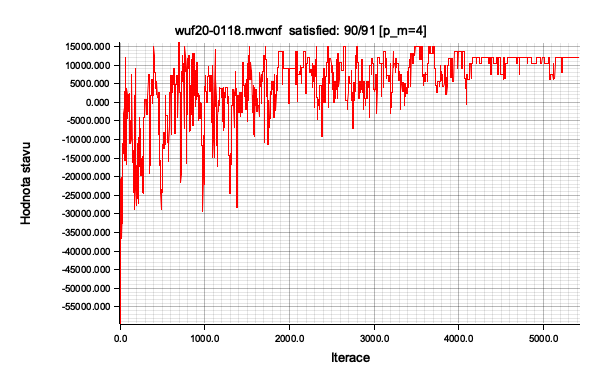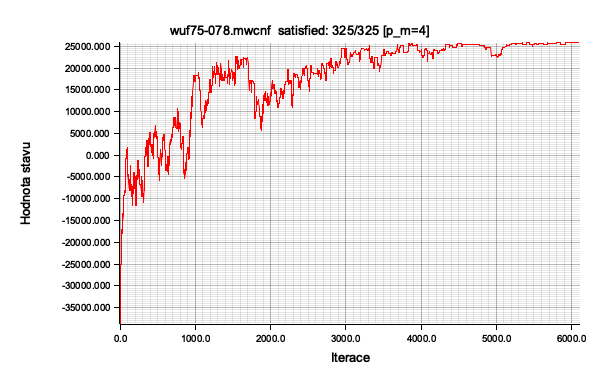

method = relative-deviation, last_values_n = 800

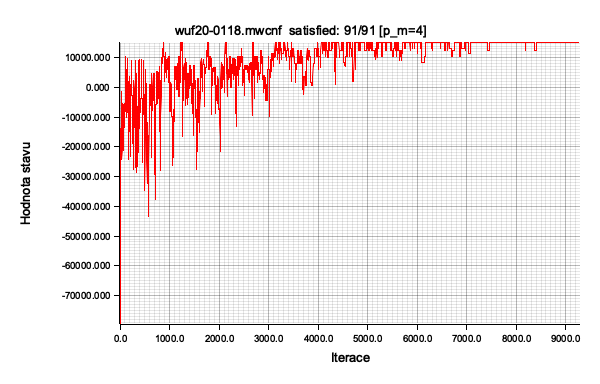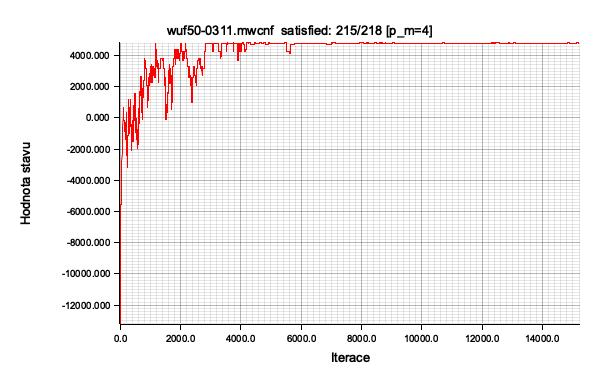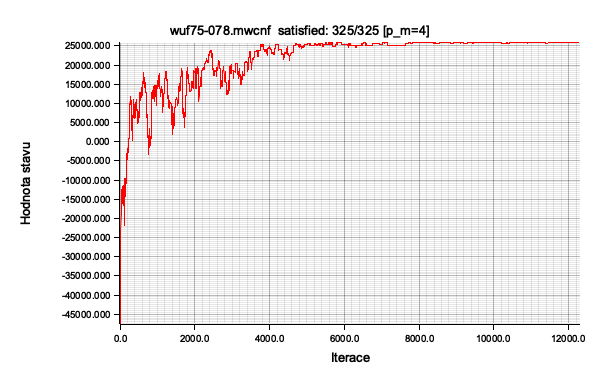

method = relative-deviation, last_values_n = 3000

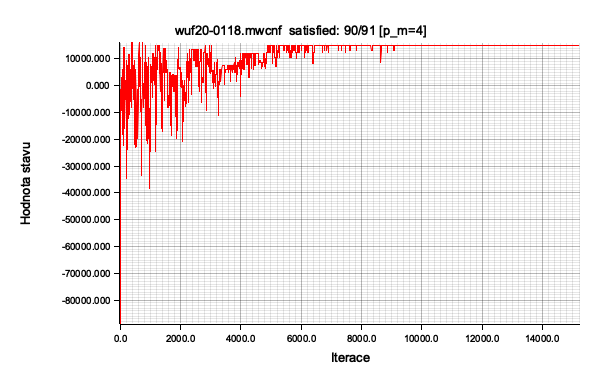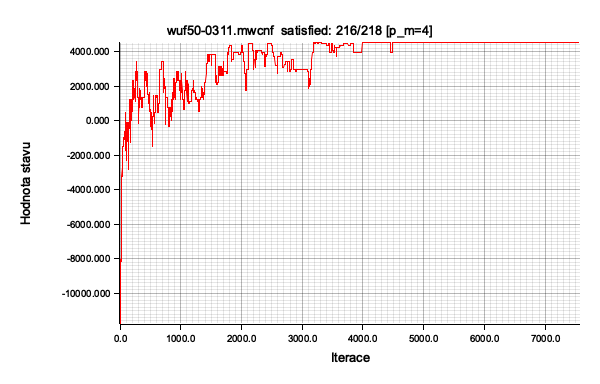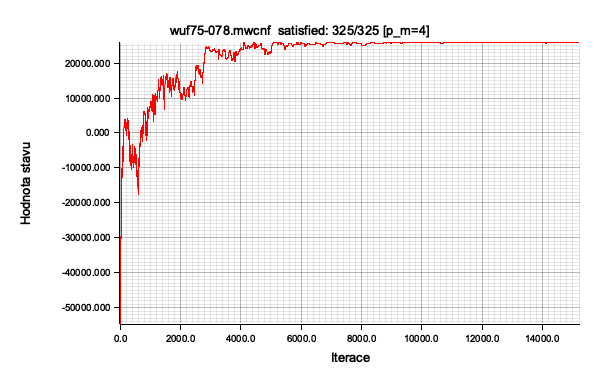


### Black box

Nyní nastavené SA pustím pro všechny datasety, pro které jsou známé optima: wuf20-71 wuf20-91 wuf50-218 wuf75-325. 

In [125]:
import pandas as pd
import math

pd.options.display.max_rows = 100
stats = pd.read_csv('./data/output-big.csv', sep=' ', names=['datacategory', 'size', 'dataset', 'optimum', 'value', 'solved'])

stats['change'] = abs(stats['optimum'] - stats['value']) / stats['optimum']

#### Průměrná relativní chyba

V následující tabulce můžeme vidět zprůměrovanou relativní chybu $\frac{optimum - value}{optimum}$ pro každou kategorii datasetu.

V této tabulce je vidět, že SA fungovalo velmi dobře pro datasety typu **M** a **N**, kde byla chyba malá.

Naopak velké chyby jsou u všech velikostí typu **Q** a **R** kromě **wuf20-71**. 

Například u **wuf20-91 R** to může být například tím, že kvůli penalizaci jsou některé hodnoty dokonce záporné, čímž pak vzníká velká relativní chyba. Minimální hodnoty vypisuji v další tabulce.

In [123]:
pd.DataFrame(stats.groupby(['datacategory', 'size'])['change'].mean().apply(lambda x: f'{x * 100:.4f} %'))

change
datacategory size              
wuf20-71     M         0.0000 %
             N         0.0131 %
             Q         0.6709 %
             R         0.7951 %
wuf20-91     M         0.3389 %
             N         2.2405 %
             Q      4678.6320 %
             R     50997.1336 %
wuf50-218    M         0.9298 %
             N         3.5499 %
             Q       645.1460 %
             R      1449.7287 %
wuf75-325    M         1.7947 %
             N         3.9659 %
             Q       236.8510 %
             R       220.7466 %

Minimální hodnoty nalezených stavů pro každou kategorii

In [131]:
pd.DataFrame(stats.groupby(['datacategory', 'size'])['value'].min())

value
datacategory size       
wuf20-71     M      1277
             N     35854
             Q      2166
             R     15971
wuf20-91     M       521
             N    -33141
             Q      -891
             R     -9950
wuf50-218    M      2041
             N     33940
             Q      1997
             R      3909
wuf75-325    M     14548
             N     86945
             Q      5341
             R     28664

#### Relativní četnosti počtů splněných klauzulí

Následující tabulka zobrazuje relativní četnosti počtů nalezených klauzulí.
Opět můžeme pozorovat lepší výsledky pro menší **wuf20-71**, **wuf20-91** a jednodušší sady **M** a **N**, kde je úspěšnost splnění všech klauzulí nad 95 %.

Počet nesplněných klauzulí se pohybuje v rozmezí 1 - 8.

In [124]:
pd.DataFrame(stats.groupby(['datacategory', 'size'])['solved'].value_counts(normalize=True).apply(lambda x: f'{x * 100:.2f} %'))

solved
datacategory size solved          
wuf20-71     M    71      100.00 %
             N    71      100.00 %
             Q    71       98.40 %
                  70        1.60 %
             R    71       98.90 %
                  70        1.10 %
wuf20-91     M    91       99.10 %
                  90        0.70 %
                  88        0.10 %
                  89        0.10 %
             N    91       95.40 %
                  90        3.80 %
                  89        0.70 %
                  88        0.10 %
             Q    90       56.30 %
                  89       23.60 %
                  91       18.10 %
                  88        1.80 %
                  87        0.20 %
             R    90       51.50 %
                  89       24.60 %
                  91       19.40 %
                  88        4.10 %
                  87        0.40 %
wuf50-218    M    218      94.80 %
                  217       4.00 %
                  216       1.20 %
             N    218      88.10 %
                  217       6.30 %
                  216       3.20 %
                  215       1.70 %
                  214       0.70 %
             Q    216      38.40 %
                  217      26.50 %
                  215      22.80 %
                  214       7.60 %
                  218       2.70 %
                  213       1.70 %
                  212       0.30 %
             R    216      36.30 %
                  217      23.50 %
                  215      22.60 %
                  214      11.10 %
                  213       3.10 %
                  218       2.60 %
                  212       0.60 %
                  211       0.20 %
wuf75-325    M    325      87.00 %
                  324       9.00 %
                  322       3.00 %
                  323       1.00 %
             N    325      78.00 %
                  324      15.00 %
                  322       4.00 %
                  323       2.00 %
                  321       1.00 %
             Q    322      29.00 %
                  323      25.00 %
                  321      17.00 %
                  324      15.00 %
                  320       9.00 %
                  318       2.00 %
                  319       2.00 %
                  325       1.00 %
             R    322      31.00 %
                  321      22.00 %
                  323      21.00 %
                  320      10.00 %
                  324      10.00 %
                  319       6.00 %


## Závěr

V tomto experimentu jsem implementoval řešení optimalizačního váženého 3-SAT problému (MWSAT) metodou simulovaného ochlazování. Následně jsem ve white box fázi ladil parametry, které ovlivňují chování a dobu běhu této heuristiky. Toto ladění proběhlo na různě velkých vzorcích dat.
Nakonec jsem změřil úspěšnost na všech datech s nalezenými parametry z white box fáze.
Experiment ukázal, že lze problém řešit nedeterministicky, což je rychlejší než projít všechny stavy, ale kvalita výsledku velmi závisí na nastavení SA.

V tomto experimentu se nastavení ukázalo jako vhodné pro data typu **M** a **N**. Pro ostatní data výsledky nebyly moc uspokojivé.